# TVB simulations in nipype!

In [1]:
# https://groups.google.com/forum/#!topic/tvb-users/ODsL9bkGLHQ

import warnings
warnings.filterwarnings('ignore')
import os, sys, scipy.io, numpy as np
from nipype import Node, Function, Workflow

cwd = os.getcwd()

# https://miykael.github.io/nipype_tutorial/notebooks/basic_workflow.html

def make_model(model_name, parameters):# done
    import warnings, pickle, os
    warnings.filterwarnings('ignore')
    from tvb.simulator.lab import models
    import numpy as np
    mod = getattr(models, model_name)
    model_class = mod(**dict(parameters))
    with open("model_class.p", "wb") as f:
        pickle.dump(model_class, f)
    model_class = os.path.abspath("model_class.p")
    return model_class

def load_connectivity_mat(in_file, normalize=False):
    import scipy.io, pickle, os
    datamat = scipy.io.loadmat(in_file)
    sc_weights = datamat['sc_weights']
    if normalize:
        sc_weights = sc_weights / sc_weights.max()
    tract_lengths = datamat['tract_lengths']
    scipy.io.savemat('sc_weights.mat',{'sc_weights': sc_weights})
    scipy.io.savemat('tract_lengths.mat',{'tract_lengths': tract_lengths})
    sc_weights = os.path.abspath("sc_weights.mat")
    tract_lengths = os.path.abspath("tract_lengths.mat")
    return sc_weights, tract_lengths
    
def make_connectivity(weights, lengths):
    import warnings, pickle, os, scipy.io
    warnings.filterwarnings('ignore')
    weights_mat = scipy.io.loadmat(weights); weights = weights_mat['sc_weights']
    lengths_mat = scipy.io.loadmat(lengths); lengths = lengths_mat['tract_lengths']
    from tvb.simulator.lab import connectivity
    conn_class = connectivity.Connectivity(weights=weights, tract_lengths=lengths)
    with open("conn_class.p", "wb") as f:
        pickle.dump(conn_class, f)
    conn_class = os.path.abspath("conn_class.p")
    return conn_class

def make_integrator(integrator_name, base_dt, noise_type, noise_val):
    import sys, numpy, warnings, pickle, os
    warnings.filterwarnings('ignore')
    sys.modules['mtrand'] = numpy.random.mtrand 
    from tvb.simulator.lab import integrators, noise
    temp_integrator = getattr(integrators,integrator_name)
    temp_noise = getattr(noise, noise_type)
    noise = temp_noise(nsig = numpy.array([noise_val]))
    integrator_class = temp_integrator(dt = base_dt, noise = noise)
    #integrator_class = temp_integrator(dt = base_dt)
    with open("integrator_class.p", "wb") as f:
        pickle.dump(integrator_class, f)
    integrator_class = os.path.abspath("integrator_class.p")
    return integrator_class

def make_monitors(monitor_types, periods):
    import warnings, sys, numpy, pickle, os
    warnings.filterwarnings('ignore')
    sys.modules['mtrand'] = numpy.random.mtrand
    from tvb.simulator.lab import monitors
        
    monitor_class = []
    for i in range(len(monitor_types)):
        monitor_tmp = getattr(monitors,monitor_types[i])
        monitor_tmp2 = monitor_tmp(period = periods[i])
        monitor_class.append(monitor_tmp2)
        
    monitor_class = tuple(monitor_class)
    with open("monitor_class.p", "wb") as f:
        pickle.dump(monitor_class, f)
    monitor_class = os.path.abspath("monitor_class.p")
    return monitor_class


def run_simulation(out_file, model_input, conn_input, integrator_input, monitor_input, global_coupling = 0.1, conduction_speed=3.0, simulation_length=10000.0):
    import warnings, sys, numpy, pickle, os, scipy.io
    warnings.filterwarnings('ignore')
    sys.modules['mtrand'] = numpy.random.mtrand
    
    with open(model_input, "rb") as f:
        model_input = pickle.load(f)
    with open(conn_input, "rb") as f:
        conn_input = pickle.load(f)
    with open(integrator_input, "rb") as f:
        integrator_input = pickle.load(f)
    with open(monitor_input, "rb") as f:
        monitor_input = pickle.load(f)

    from tvb.simulator.lab import *
    wm_coupling = coupling.Linear(a = global_coupling)
    sim = simulator.Simulator(model = model_input, connectivity = conn_input, coupling = wm_coupling,
                             integrator = integrator_input, monitors = monitor_input,
                             simulation_length = simulation_length, conduction_speed = conduction_speed)
    
    sim.configure()
    sim_output = sim.run()
    scipy.io.savemat('sim_output.mat',{'sim_output': sim_output})
    abs_out_file = os.path.abspath("sim_output.mat") # fix this
    return abs_out_file

##### NIPYPE PORTION
# https://miykael.github.io/nipype_tutorial/notebooks/basic_function_interface.html

model = Node(
    Function(
        input_names=['model_name', 'parameters'],
        output_names=['model_class'],
        function=make_model
    ),
    name='create_model'
)
 
sc_loader = Node(
    Function(
        input_names=['in_file', 'normalize'],
        output_names=['sc_weights', 'tract_lengths'],
        function=load_connectivity_mat
    ),
    name='load_sc_mat'
)

sc = Node(
    Function(
        input_names=['weights', 'lengths'],
        output_names=['conn_class'],
        function=make_connectivity
    ),
    name='create_sc'
)

integrator = Node(
    Function(
        input_names=['integrator_name','base_dt','noise_type','noise_val'],
        output_names=['integrator_class'],
        function=make_integrator
    ),
    name='create_integrator'
)

monitors = Node(
    Function(
        input_names=['monitor_types','periods'],
        output_names=['monitor_class'],
        function=make_monitors
    ),
    name='create_monitors'
)

simulate = Node(
    Function(
        input_names=['out_file', 'model_input', 'conn_input', 'integrator_input', 'monitor_input',
                     'global_coupling', 'conduction_speed', 'simulation_length'],
        output_names=['abs_out_file'],
        function=run_simulation
    ),
    name='create_simulation'
)



In [2]:
# https://miykael.github.io/nipype_tutorial/notebooks/basic_workflow.html

workflow = Workflow(name='tvb_demo', base_dir=os.getcwd())
workflow.connect([
    (model, simulate, [("model_class", "model_input")]),
    (sc_loader, sc, [("sc_weights", "weights"), ("tract_lengths", "lengths")]),
    (sc, simulate, [("conn_class", "conn_input")]),
    (integrator, simulate, [("integrator_class", "integrator_input")]),
    (monitors, simulate, [("monitor_class", "monitor_input")])
])

# NOW DEFINE YOUR INPUTS
model.inputs.model_name = 'Generic2dOscillator'
model.inputs.parameters = [('a',1), ('b',1)]
sc_loader.inputs.in_file = os.path.join(cwd, 'input', 'sub-01_connectivity.mat')
sc_loader.inputs.normalize = False 
integrator.inputs.integrator_name = 'HeunStochastic'
integrator.inputs.base_dt = 0.1
integrator.inputs.noise_type = 'Additive'
#integrator.inputs.noise_val = 0.0001
monitors.inputs.monitor_types = ['Bold', 'TemporalAverage']
monitors.inputs.periods = [2000.0, 10.0]
simulate.inputs.out_file = os.path.join(cwd, 'tvb_test1.mat')
#simulate.inputs.global_coupling = 0.1
#simulate.inputs.conduction_speed = 2.0
simulate.inputs.simulation_length = 10000.0


# ITERABLES
integrator.iterables = ("noise_val", [0.0001, 0.001, 0.01])
#simulate.iterables = [('global_coupling', [0.1, 0.5, 1.0])]
#sc_loader.iterables = [('in_file', [os.path.join(cwd, 'input', 'sub-01_connectivity.mat'), os.path.join(cwd, 'input', 'sub-02_connectivity.mat'), os.path.join(cwd, 'input', 'sub-03_connectivity.mat')])]
simulate.iterables = [('global_coupling', np.arange(0.0, 5.1, 0.5)), ('conduction_speed', [1,2])]


# ^ move constants to top node; have initial node with subject list 
# make datasink at the end to clean things up 
#def run_simulation(out_file, model_input, conn_input, integrator_input, monitor_input, global_coupling = 0.1, conduction_speed=2.0, simulation_length=1000.0):


In [3]:
# Write graph of type orig
workflow.write_graph(graph2use='exec', dotfilename='./graph_orig.dot')

180809-23:12:11,893 nipype.workflow INFO:
	 Generated workflow graph: /Users/escience/hackademy/tvb_nipype/graph_orig.png (graph2use=exec, simple_form=True).


u'/Users/escience/hackademy/tvb_nipype/graph_orig.png'

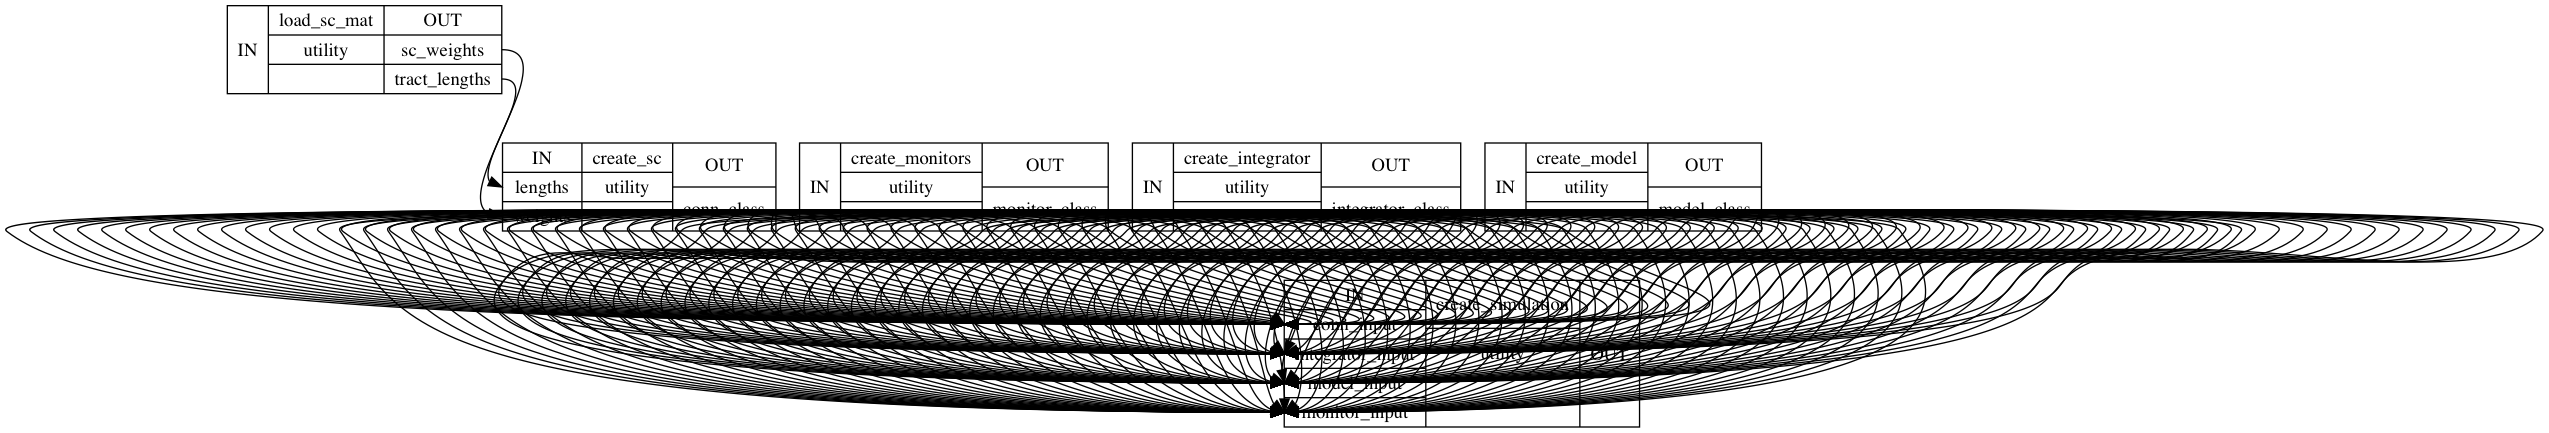

In [4]:
from IPython.display import Image
Image(filename="graph_orig_detailed.png")

In [5]:
#workflow.run()
workflow.run('MultiProc', plugin_args={'n_procs': 8})

180809-23:14:11,250 nipype.workflow INFO:
	 Workflow tvb_demo settings: ['check', 'execution', 'logging', 'monitoring']
180809-23:14:11,376 nipype.workflow INFO:
	 Running in parallel.
180809-23:14:11,388 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 6 jobs ready. Free memory (GB): 7.20/7.20, Free processors: 8/8.
180809-23:14:11,474 nipype.workflow INFO:
	 [Node] Setting-up "tvb_demo.create_integrator" in "/Users/escience/hackademy/tvb_nipype/tvb_demo/_noise_val_0.01/create_integrator".
180809-23:14:11,514 nipype.workflow INFO:
	 [Node] Running "create_integrator" ("nipype.interfaces.utility.wrappers.Function")
180809-23:14:11,530 nipype.workflow INFO:
	 [Node] Setting-up "tvb_demo.load_sc_mat" in "/Users/escience/hackademy/tvb_nipype/tvb_demo/load_sc_mat".
180809-23:14:11,531 nipype.workflow INFO:
	 [Node] Setting-up "tvb_demo.create_monitors" in "/Users/escience/hackademy/tvb_nipype/tvb_demo/create_monitors".
180809-23:14:11,541 nipype.workflow INFO:
	 [Node] Setting-up "

180809-23:17:25,848 nipype.workflow INFO:
	 [Node] Finished "tvb_demo.create_simulation".
180809-23:17:25,876 nipype.workflow INFO:
	 [Node] Finished "tvb_demo.create_simulation".
180809-23:17:25,916 nipype.workflow INFO:
	 [Node] Finished "tvb_demo.create_simulation".
180809-23:17:26,77 nipype.workflow INFO:
	 [Node] Finished "tvb_demo.create_simulation".
180809-23:17:27,631 nipype.workflow INFO:
	 [Job 9] Completed (tvb_demo.create_simulation).
180809-23:17:27,637 nipype.workflow INFO:
	 [Job 10] Completed (tvb_demo.create_simulation).
180809-23:17:27,642 nipype.workflow INFO:
	 [Job 11] Completed (tvb_demo.create_simulation).
180809-23:17:27,648 nipype.workflow INFO:
	 [Job 12] Completed (tvb_demo.create_simulation).
180809-23:17:27,654 nipype.workflow INFO:
	 [Job 13] Completed (tvb_demo.create_simulation).
180809-23:17:27,662 nipype.workflow INFO:
	 [Job 14] Completed (tvb_demo.create_simulation).
180809-23:17:27,670 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 58 jobs

180809-23:20:20,109 nipype.workflow INFO:
	 [Node] Setting-up "tvb_demo.create_simulation" in "/Users/escience/hackademy/tvb_nipype/tvb_demo/_noise_val_0.01/_conduction_speed_1_global_coupling_0.0/create_simulation".
180809-23:20:20,134 nipype.workflow INFO:
	 [Node] Running "create_simulation" ("nipype.interfaces.utility.wrappers.Function")
180809-23:20:20,153 nipype.workflow INFO:
	 [Node] Setting-up "tvb_demo.create_simulation" in "/Users/escience/hackademy/tvb_nipype/tvb_demo/_noise_val_0.01/_conduction_speed_2_global_coupling_0.0/create_simulation".
180809-23:20:20,186 nipype.workflow INFO:
	 [Node] Running "create_simulation" ("nipype.interfaces.utility.wrappers.Function")
180809-23:20:20,311 nipype.workflow INFO:
	 [Node] Setting-up "tvb_demo.create_simulation" in "/Users/escience/hackademy/tvb_nipype/tvb_demo/_noise_val_0.0001/_conduction_speed_1_global_coupling_4.0/create_simulation".
180809-23:20:20,337 nipype.workflow INFO:
	 [Node] Running "create_simulation" ("nipype.inter

180809-23:23:22,48 nipype.workflow INFO:
	 [MultiProc] Running 8 tasks, and 36 jobs ready. Free memory (GB): 5.60/7.20, Free processors: 0/8.                     
                     Currently running:
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
180809-23:23:25,921 nipype.workflow INFO:
	 [Node] Finished "tvb_demo.create_simulation".
180809-23:23:26,51 nipype.workflow INFO:
	 [Job 29] Completed (tvb_demo.create_simulation).
180809-23:23:26,58 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 36 jobs ready. Free memory (GB): 5.80/7.20, Free processors: 1/8.                     
                     Currently runni

180809-23:26:21,759 nipype.workflow INFO:
	 [Node] Finished "tvb_demo.create_simulation".
180809-23:26:22,239 nipype.workflow INFO:
	 [Job 37] Completed (tvb_demo.create_simulation).
180809-23:26:22,248 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 28 jobs ready. Free memory (GB): 5.80/7.20, Free processors: 1/8.                     
                     Currently running:
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
180809-23:26:22,464 nipype.workflow INFO:
	 [Node] Setting-up "tvb_demo.create_simulation" in "/Users/escience/hackademy/tvb_nipype/tvb_demo/_noise_val_0.01/_conduction_speed_1_global_coupling_5.0/create_simulation".
180809-23:26:22,500 nipype.workf

180809-23:29:30,677 nipype.workflow INFO:
	 [Node] Running "create_simulation" ("nipype.interfaces.utility.wrappers.Function")
180809-23:29:30,697 nipype.workflow INFO:
	 [Node] Setting-up "tvb_demo.create_simulation" in "/Users/escience/hackademy/tvb_nipype/tvb_demo/_noise_val_0.01/_conduction_speed_2_global_coupling_5.0/create_simulation".
180809-23:29:30,723 nipype.workflow INFO:
	 [Node] Running "create_simulation" ("nipype.interfaces.utility.wrappers.Function")
180809-23:29:32,493 nipype.workflow INFO:
	 [MultiProc] Running 8 tasks, and 20 jobs ready. Free memory (GB): 5.60/7.20, Free processors: 0/8.                     
                     Currently running:
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
             

180809-23:32:30,900 nipype.workflow INFO:
	 [Node] Setting-up "tvb_demo.create_simulation" in "/Users/escience/hackademy/tvb_nipype/tvb_demo/_noise_val_0.01/_conduction_speed_1_global_coupling_2.0/create_simulation".
180809-23:32:30,931 nipype.workflow INFO:
	 [Node] Running "create_simulation" ("nipype.interfaces.utility.wrappers.Function")
180809-23:32:32,685 nipype.workflow INFO:
	 [MultiProc] Running 8 tasks, and 12 jobs ready. Free memory (GB): 5.60/7.20, Free processors: 0/8.                     
                     Currently running:
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
180809-23:32:35,8 nipype.workflow IN

180809-23:35:39,72 nipype.workflow INFO:
	 [Node] Running "create_simulation" ("nipype.interfaces.utility.wrappers.Function")
180809-23:35:39,84 nipype.workflow INFO:
	 [Node] Setting-up "tvb_demo.create_simulation" in "/Users/escience/hackademy/tvb_nipype/tvb_demo/_noise_val_0.0001/_conduction_speed_1_global_coupling_3.0/create_simulation".
180809-23:35:39,118 nipype.workflow INFO:
	 [Node] Running "create_simulation" ("nipype.interfaces.utility.wrappers.Function")
180809-23:35:40,891 nipype.workflow INFO:
	 [Job 60] Completed (tvb_demo.create_simulation).
180809-23:35:40,898 nipype.workflow INFO:
	 [MultiProc] Running 7 tasks, and 5 jobs ready. Free memory (GB): 5.80/7.20, Free processors: 1/8.                     
                     Currently running:
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * 

180809-23:39:05,887 nipype.workflow INFO:
	 [Node] Finished "tvb_demo.create_simulation".
180809-23:39:06,24 nipype.workflow INFO:
	 [Node] Finished "tvb_demo.create_simulation".
180809-23:39:07,141 nipype.workflow INFO:
	 [Job 66] Completed (tvb_demo.create_simulation).
180809-23:39:07,149 nipype.workflow INFO:
	 [Job 67] Completed (tvb_demo.create_simulation).
180809-23:39:07,159 nipype.workflow INFO:
	 [MultiProc] Running 5 tasks, and 0 jobs ready. Free memory (GB): 6.20/7.20, Free processors: 3/8.                     
                     Currently running:
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
                       * tvb_demo.create_simulation
180809-23:39:07,875 nipype.workflow INFO:
	 [Node] Finished "tvb_demo.create_simulation".
180809-23:39:09,142 nipype.workflow INFO:
	 [Job 68] Completed (tvb_demo.create_si

In [6]:
!tree tvb_demo/ -I '*txt|*pklz|_report|*.json|*js|*.dot|*.html'

tvb_demo/
├── _noise_val_0.0001
│   ├── _conduction_speed_1_global_coupling_0.0
│   │   └── create_simulation
│   │       └── sim_output.mat
│   ├── _conduction_speed_1_global_coupling_0.5
│   │   └── create_simulation
│   │       └── sim_output.mat
│   ├── _conduction_speed_1_global_coupling_1.0
│   │   └── create_simulation
│   │       └── sim_output.mat
│   ├── _conduction_speed_1_global_coupling_1.5
│   │   └── create_simulation
│   │       └── sim_output.mat
│   ├── _conduction_speed_1_global_coupling_2.0
│   │   └── create_simulation
│   │       └── sim_output.mat
│   ├── _conduction_speed_1_global_coupling_2.5
│   │   └── create_simulation
│   │       └── sim_output.mat
│   ├── _conduction_speed_1_global_coupling_3.0
│   │   └── create_simulation
│   │       └── sim_output.mat
│   ├── _conduction_speed_1_global_coupling_3.5
│   │   └── create_simulation
│   │       └── sim_output.mat
│   ├── _conduction_speed_1_global_coupling_4.0
│   │   └── create_simulation
│   │       └── si